"""You flip a coin 100 times and observe 45 heads.
Use the Metropolis Hastings algorithm to determine the posterior distribution for the probability of obtaining heads in a single coin flip"""

In [1]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tfd = tfp.distributions

/opt/conda/lib/python3.8/site-packages/tensorflow_probability/python/__init__.py:70: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  warnings.warn(


2023-06-29 21:13:37.893948: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 21:13:38.458051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 129 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7
/opt/conda/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


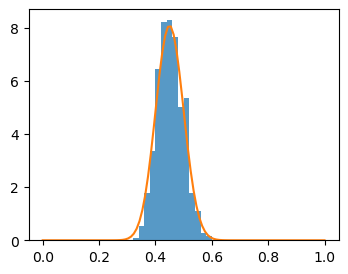

In [2]:
def log_likelihood(p):
    N=100
    h=45
    likelihood = tfd.Binomial(N,probs=p).log_prob(h)
    prior = tfd.Uniform().log_prob(p)
    return likelihood + prior
    
@tf.function
def run_sampler():
    # specify the Metropolis Hastings inner kernel
    inner_kernel = tfp.mcmc.RandomWalkMetropolis(log_likelihood)
    # we need to keep the probability between 0 and 1 so we use a sigmoid bijector
    kernel = tfp.mcmc.TransformedTransitionKernel(inner_kernel, tfp.bijectors.Sigmoid())
    # now we can run the actual MCMC chain
    samples, kernels_results = tfp.mcmc.sample_chain(num_results=2000,
        current_state=0.5,
        kernel=kernel,
        num_burnin_steps=50)
    return samples
    
# run the sampler
s = run_sampler()

# plot the posterior density from the samples
plt.figure(figsize=(4,3))
hist = plt.hist(s.numpy(),bins=50,range=(0,1),density=True,alpha=0.75)
# we will also plot the analytical posterior
x = np.linspace(0,1,100)
n_heads = 45
N = 100
posterior = tfd.Beta(concentration1=1+n_heads, concentration0=1+N-n_heads)
plt.plot(x,posterior.prob(x))
plt.show()